In [1]:
"""
Intra-Chain C-C, C-G, and G-G Contact Enrichment Analysis Script for Submission

Author: Qin Zhang
Created: 2025-06-11
Last Modified: 2025-06-11
License: MIT License

This script analyzes intra-chain C-C, C-G, and G-G contact enrichments in RNA systems under varying salt concentrations.
"""
# %% Cell 1: Data Configuration and Core Analysis
import MDAnalysis as mda
import numpy as np
import pickle
import matplotlib.pyplot as plt
from MDAnalysis.analysis import distances
import os
from tqdm import tqdm
"""
Define file paths for RNA systems (3xG4C2 and 5xG4C2) under different salt conditions.
Data source: Zenodo repository (DOI: 10.5281/zenodo.15608685)
"""
conditions_3x = {
    "neutral":   "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_Na_neutral/lake_10us/",
    "17mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_17mMNaCl_10mMMgCl2/lake_10us/",
    "35mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_35mMNaCl_21mMMgCl2/lake_10us/",
    "70mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_70mMNaCl_42mMMgCl2/lake_10us/",
    "139mMNaCl": "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_139mMNaCl_83mMMgCl2/lake_10us/",
    "278mMNaCl": "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_278mMNaCl_167mMMgCl2/lake_10us/",
    "487mMNaCl": "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_487mMNaCl_292mMMgCl2/lake_10us/",
    "696mMNaCl": "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_696mMNaCl_417mMMgCl2/lake_10us/"
}
conditions_5x ={
    "neutral":   "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_Na_neutral/lake_10us/",
    "17mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_17mMNaCl_10mMMgCl2/lake_10us/",
    "35mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_35mMNaCl_21mMMgCl2/lake_10us/",
    "70mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_70mMNaCl_42mMMgCl2/lake_10us/",
    "139mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_139mMNaCl_83mMMgCl2/lake_10us/",
    "278mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_278mMNaCl_167mMMgCl2/lake_10us/",
    "487mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_487mMNaCl_292mMMgCl2/lake_10us/",
    "696mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_696mMNaCl_417mMMgCl2/lake_10us/"
}
"""
Define chain index ranges for 5xG4C2 system.
Each chain is represented as a slice object for atom selection.
"""
chains_5x = {
    "ch1": slice(0, 359),
    "ch2": slice(360, 719),
    "ch3": slice(720, 1079),
    "ch4": slice(1080, 1439),
    "ch5": slice(1440, 1799),
    "ch6": slice(1800, 2159),
    "ch7": slice(2160, 2519),
    "ch8": slice(2520, 2879),
    "ch9": slice(2880, 3239),
    "ch10": slice(3240, 3599),
    "ch11": slice(3600, 3959),
    "ch12": slice(3960, 4319)
}
"""
System configuration dictionary:
- chains: Atom index slices for each RNA chain
- conditions: Paths to simulation data under different salt conditions
- color: Color mapping for contact types in plots
"""
SYSTEMS = {
    '3xG4C2': {
        'chains': {f"ch{i}": slice(i*216, (i+1)*216) for i in range(12)}, 
        'conditions': conditions_3x,
        'color': {'CC': '#1f77b4', 'CG': '#ff7f0e', 'GG': '#2ca02c'}
    },
    '5xG4C2': {
        'chains': chains_5x,
        'conditions': conditions_5x,
        'color': {'CC': '#aec7e8', 'CG': '#ffbb78', 'GG': '#98df8a'}
    }
}
# Parameters
SALT_CONCENTRATIONS = [0, 17, 35, 70, 139, 278, 487, 696]  # mM NaCl
REPLICAS = ['C1', 'C2', 'C3', 'C4']  # Simulation replicas
CONTACT_TYPES = ['CC', 'CG', 'GG']  # Contact types (C-C, C-G, G-G)

def analyze_system(system_config, condition_path, cond_name):
    """
    Analyze intra-chain contact enrichments for a specific system and condition.
    
    Parameters:
        system_config (dict): System configuration (chains, colors, etc.)
        condition_path (str): Path to simulation data for the condition
        cond_name (str): Condition name (e.g., '487mMNaCl')
        
    Returns:
        dict: Global mean and standard deviation of contact enrichments
    """
    # Initialize results for each replica and contact type
    replica_means = {ct: {replica: np.nan for replica in REPLICAS} for ct in CONTACT_TYPES}  # Initialized to np.nan
    
    for replica in REPLICAS:
        gro_path = os.path.join(condition_path, replica, "RNA.gro")
        xtc_path = os.path.join(condition_path, replica, "RNA_clusterRNA.xtc")
        
        if not (os.path.exists(gro_path) and os.path.exists(xtc_path)):
            continue
            
        u = mda.Universe(gro_path, xtc_path)
        results = {ct: [] for ct in CONTACT_TYPES}
        
        # Prepare chain data with C and G residue selections
        chains = {}
        for chain_name, slc in system_config['chains'].items():
            chain = u.atoms[slc]
            C = chain.select_atoms("resname RC and name SC3") # C residue SC3 atoms
            G = chain.select_atoms("resname RG and name SC3") # G residue SC3 atoms
            chains[chain_name] = {"C": C, "G": G}
        
        # Calculate theoretical intra-chain contact ratios (combinatorial)
        c_counts = [len(chain["C"]) for chain in chains.values()]
        g_counts = [len(chain["G"]) for chain in chains.values()]

        # Theoretical number of contacts within chain
        theory_CC = sum(c*(c-1)/2 for c in c_counts)  # Combinations of C-C within chains
        theory_CG = sum(c*g for c,g in zip(c_counts,g_counts))  # C-G pairs within chains
        theory_GG = sum(g*(g-1)/2 for g in g_counts)  # Combinations of G-G within chains
        total_theory = theory_CC + theory_CG + theory_GG

        if total_theory == 0:  # Prevent division by zero
            theory_ratios = {"CC": 0, "CG": 0, "GG": 0}
        else:
            theory_ratios = {
                "CC": theory_CC/total_theory,
                "CG": theory_CG/total_theory,
                "GG": theory_GG/total_theory
            }
        # Trajectory analysis (intra-chain)
        for ts in u.trajectory[::50]:
            actual_CC, actual_CG, actual_GG = 0, 0, 0
            
            for chain in chains.values():
                C = chain["C"]
                G = chain["G"]
                
                # C-C contacts within the same chain
                if len(C) >= 2:
                    dist = distances.self_distance_array(C.positions, box=ts.dimensions)
                    actual_CC += np.sum(dist < 6) ## please change dist < 9 to have figureS3b in manuscript
                
                # C-G contacts within the same chain
                if len(C)>=1 and len(G)>=1:
                    dist = distances.distance_array(C.positions, G.positions, box=ts.dimensions)
                    actual_CG += np.sum(dist < 6) ## please change dist < 9 to have figureS3b in manuscript
                
                # G-G contacts within the same chain
                if len(G) >= 2:
                    dist = distances.self_distance_array(G.positions, box=ts.dimensions)
                    actual_GG += np.sum(dist < 6) ## please change dist < 9 to have figureS3b in manuscript

            total = actual_CC + actual_CG + actual_GG
            if total > 0:
                # Calculate enrichment/depletion relative to theoretical ratio
                for ct, val in zip(CONTACT_TYPES, [actual_CC, actual_CG, actual_GG]):
                    results[ct].append(val/total - theory_ratios[ct])
            else:
                for ct in CONTACT_TYPES:
                    results[ct].append(np.nan)
                    
        # Store replica mean (only for valid data)
        for ct in CONTACT_TYPES:
            clean_data = np.array(results[ct])
            clean_data = clean_data[~np.isnan(clean_data)]
            if len(clean_data) > 0:
                # Store the mean of valid replicates, keep np.nan for invalid cases
                replica_means[ct][replica] = np.mean(clean_data)

    # Calculate global statistics (mean and SD across replicas)
    stats = {}
    print(f"\n{'='*30}")
    print(f"Condition: {cond_name}")
    print(f"{'='*30}")
    for ct in CONTACT_TYPES:
        valid_means = [mean for mean in replica_means[ct].values() if not np.isnan(mean)]
        n_replicas = len(valid_means)
        
        if n_replicas == 0:
            global_mean = 0.0
            sd = 0.0
        else:
            global_mean = np.mean(valid_means)
            sd = np.std(valid_means, ddof=1) if n_replicas >= 2 else 0.0

        stats[ct] = (global_mean, sd)

        print(f"Contact type: {ct}")
        for rep in REPLICAS:
            val = replica_means[ct][rep]
            print(f"  - {rep} mean: {val:.4f}" if not np.isnan(val) else f"  - {rep}: no data")
        print(f"  → Number of valid replicates: {n_replicas}")
        print(f"  → Global mean: {global_mean:.4f}")
        print(f"  → Standard deviation(SD): {sd:.4f}\n")
    
    return stats
    
# Execute analysis for all systems and conditions
full_results = {}
for system_name in SYSTEMS:
    full_results[system_name] = {}
    for cond_name, cond_path in SYSTEMS[system_name]['conditions'].items():
        if not os.path.exists(cond_path):
            print(f"Path does not exist: {cond_path}")
            continue
        salt = int(cond_name.replace('mMNaCl', '')) if 'mMNaCl' in cond_name else 0
        full_results[system_name][salt] = analyze_system(SYSTEMS[system_name], cond_path, cond_name)  # 添加cond_name
# Save results to pickle file for future use
with open('35_intra_chain_enrichment.pkl', 'wb') as f:
    pickle.dump(full_results, f)


Condition: neutral
Contact type: CC
  - C1 mean: 0.0290
  - C2 mean: 0.0415
  - C3 mean: 0.0280
  - C4 mean: 0.0321
  → Number of valid replicates: 4
  → Global mean: 0.0326
  → Standard deviation(SD): 0.0062

Contact type: CG
  - C1 mean: 0.0061
  - C2 mean: -0.0493
  - C3 mean: -0.0050
  - C4 mean: 0.0141
  → Number of valid replicates: 4
  → Global mean: -0.0085
  → Standard deviation(SD): 0.0283

Contact type: GG
  - C1 mean: -0.0351
  - C2 mean: 0.0078
  - C3 mean: -0.0229
  - C4 mean: -0.0462
  → Number of valid replicates: 4
  → Global mean: -0.0241
  → Standard deviation(SD): 0.0233


Condition: 17mMNaCl
Contact type: CC
  - C1 mean: -0.0283
  - C2 mean: -0.0136
  - C3 mean: -0.0349
  - C4 mean: -0.0130
  → Number of valid replicates: 4
  → Global mean: -0.0225
  → Standard deviation(SD): 0.0109

Contact type: CG
  - C1 mean: 0.0156
  - C2 mean: 0.0362
  - C3 mean: -0.0038
  - C4 mean: 0.0054
  → Number of valid replicates: 4
  → Global mean: 0.0134
  → Standard deviation(SD):

In [2]:
# %% Cell 2: Data Loading and Preparation
import pickle
import numpy as np
# Load precomputed intra-chain contact enrichment results
with open('35_intra_chain_enrichment.pkl', 'rb') as f:
    full_results = pickle.load(f)
# Define analysis parameters for plotting
salt_order = [0, 17, 35, 70, 139, 278, 487, 696]
systems = ['3xG4C2', '5xG4C2']
ctypes = ['CC', 'CG', 'GG']
# Organize data into a numpy array for plotting: [salt, system, ctype, (mean, sd)]
plot_data = np.zeros((len(salt_order), len(systems), len(ctypes), 2)) 
for i, salt in enumerate(salt_order):
    for j, sys in enumerate(systems):
        for k, ct in enumerate(ctypes):
            plot_data[i,j,k] = full_results[sys][salt][ct]


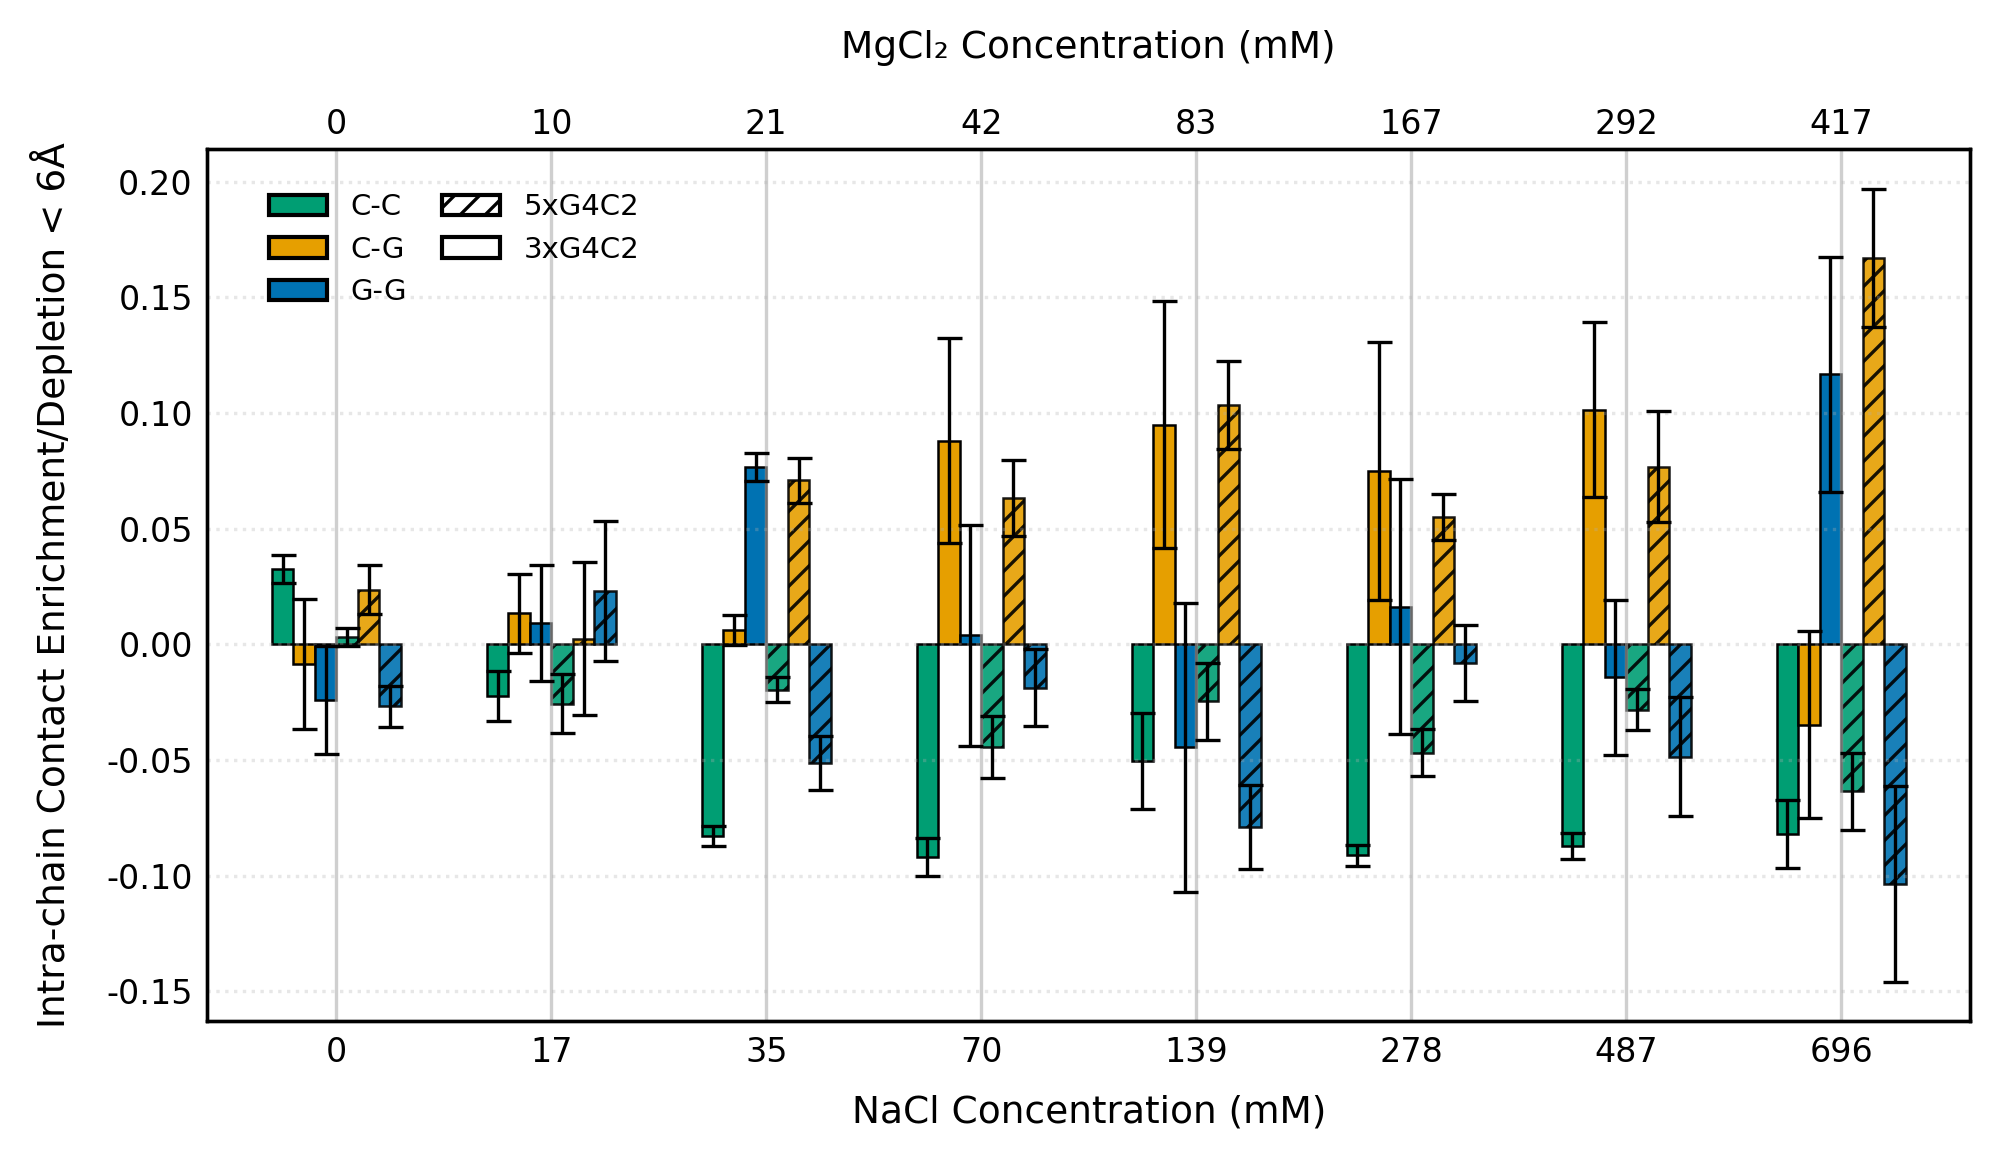

In [3]:
# %% Cell 3: Generate Publication-Quality Plot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams

rcParams.update({
    'font.sans-serif': 'DejaVu Sans', 
    'font.size': 8,            
    'axes.linewidth': 0.8,      
    'xtick.major.width': 0.8,    
    'ytick.major.width': 0.8,
    'xtick.minor.width': 0.6,   
    'ytick.minor.width': 0.6,
    'axes.labelsize': 9,         
    'axes.titlesize': 9,        
    'legend.fontsize': 7,       
    'figure.dpi': 300,          
    'figure.figsize': (6.8, 4.0),  
    'savefig.dpi': 300,         
    'hatch.linewidth': 0.8       
})
# Color mapping for contact types
COLOR_MAP = {
    'CC': '#009E73', # Orange 
    'CG': '#E69F00', # Turquoise
    'GG': '#0072B2' # Dark blue 
}

fig, ax = plt.subplots()
nacl_ticks = np.array([0, 17, 35, 70, 139, 278, 487, 696])
mgcl2_ticks = np.array([0, 10, 21, 42, 83, 167, 292, 417])  # Converted from NaCl using 0.6 ratio
x_pos = np.arange(len(nacl_ticks))
bar_width = 0.1 # Width of each bar
offset_dict = {
    '3xCC': -bar_width*2.5,
    '3xCG': -bar_width*1.5,
    '3xGG': -bar_width*0.5,
    '5xCC': bar_width*0.5,
    '5xCG': bar_width*1.5,
    '5xGG': bar_width*2.5
} # Offset for 3x and 5x systems to create grouped bars

# Plot data for each salt concentration
for sidx in range(len(nacl_ticks)):
    current_salt = nacl_ticks[sidx]

    if current_salt not in salt_order:
        continue
    
    # Plot 3xG4C2 system (solid bars)
    for i, ct in enumerate(['CC', 'CG', 'GG']):
        if np.isnan(plot_data[sidx, 0, i, 0]):  
            continue
        offset = list(offset_dict.values())[i]
        mean, err = plot_data[sidx, 0, i]
        ax.bar(x_pos[sidx] + offset, mean, bar_width,
               color=COLOR_MAP[ct], edgecolor='k', linewidth=0.6,
               yerr=err, error_kw={'elinewidth': 0.8, 'capsize': 3, 'capthick': 0.8},
               hatch=''  
              )

    # Plot 5xG4C2 system (hatched bars for contrast)
    for i, ct in enumerate(['CC', 'CG', 'GG']):
        if np.isnan(plot_data[sidx, 1, i, 0]):
            continue
        offset = list(offset_dict.values())[i+3]
        mean, err = plot_data[sidx, 1, i]
        ax.bar(x_pos[sidx] + offset, mean, bar_width,
               color=COLOR_MAP[ct], edgecolor='k', linewidth=0.6,
               yerr=err, error_kw={'elinewidth': 0.8, 'capsize': 3, 'capthick': 0.8},
               hatch='////', 
               alpha=0.9
              )

# Configure axes and labels
ax.set_xlabel('NaCl Concentration (mM)', labelpad=6)
ax.set_xlim(-0.6, len(nacl_ticks)-0.4)
ax.set_xticks(x_pos)
ax.set_xticklabels(nacl_ticks, rotation=0, ha='center') 
ax.tick_params(axis='x', which='both',length=0, bottom=False)  

# Secondary x-axis for MgCl2 concentration
ax_top = ax.twiny()
ax_top.set_xlim(ax.get_xlim())
ax_top.set_xticks(x_pos)
ax_top.set_xticklabels(mgcl2_ticks, rotation=0, ha='center', va='bottom')  
ax_top.set_xlabel('MgCl₂ Concentration (mM)', labelpad=12)
ax_top.tick_params(axis='x', length=0,   pad=2)    

ax.set_ylabel('Intra-chain Contact Enrichment/Depletion < 6Å', labelpad=8)
# ax.set_ylim(-0.1, 0.12)
# Configure y-axis ticks
ax.yaxis.set_major_locator(MultipleLocator(0.05))
# ax.yaxis.set_minor_locator(MultipleLocator(0.01))
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
ax.set_xticks(x_pos)
ax.tick_params(axis='both', which='major', length=0, width=0.8)  

legend_elements = [
    Patch(facecolor=COLOR_MAP['CC'], edgecolor='k', label='C-C'),
    Patch(facecolor=COLOR_MAP['CG'], edgecolor='k', label='C-G'),
    Patch(facecolor=COLOR_MAP['GG'], edgecolor='k', label='G-G'),
    Patch(facecolor='white', edgecolor='k', hatch='////', label='5xG4C2'),
    Patch(facecolor='white', edgecolor='k', label='3xG4C2')
]
ax.xaxis.grid(True, which='major', linestyle='-', linewidth=0.8, alpha=0.6)
ax.yaxis.grid(True, which='major', linestyle=':', linewidth=0.8, alpha=0.3)
ax.legend(handles=legend_elements, 
         loc='upper left', 
         ncol=2,
         frameon=False,
         handletextpad=0.8,
         columnspacing=1.2,
         bbox_to_anchor=(0.02, 0.98)) 

plt.tight_layout(pad=1.5)
plt.savefig('FigureS3b_figureS5b.png',
            dpi=300, 
            format='png')
plt.show()